In [36]:
!pip install wandb tensorflow_probability tensorflow_addons

In [37]:
from tensorflow.keras.layers import Add, Dense, Dropout, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError
from tensorflow_addons.metrics import RSquare

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Plotting

In [38]:
def plot_prediction(targets, predictions, max_subplots=3):
  plt.figure(figsize=(12, 15))
  max_n = min(max_subplots, len(targets))
  for n in range(max_n):
    # input
    plt.subplot(max_n, 1, n+1)
    plt.ylabel('Solar irradiance [kW-hr/m^2/day]')
    plt.plot(np.arange(targets.shape[1]-horizon), targets[n, :-horizon, 0, -1], label='Inputs', marker='.', zorder=-10)

    # real
    plt.scatter(np.arange(targets.shape[1]-horizon, targets.shape[1]), targets[n, -horizon:, 0, -1], edgecolors='k', label='Targets', c='#2cb01d', s=64)
    
    # predicted
    plt.scatter(np.arange(targets.shape[1]-horizon, targets.shape[1]), predictions[n, :, 0, -1], marker='X', edgecolors='k', label='Predictions', c='#fe7e0f', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [day]')
  plt.show()

In [39]:
def patch_similarity_plot(pos):
  similarity_scores = np.dot(
      pos, np.transpose(pos)
  ) / (
      np.linalg.norm(pos, axis=-1)
      * np.linalg.norm(pos, axis=-1)
  )

  plt.figure(figsize=(7, 7), dpi=300)
  ax = sns.heatmap(similarity_scores, center=0)
  ax.set_title("Spatial Positional Embedding")
  ax.set_xlabel("Patch")
  ax.set_ylabel("Patch")
  plt.show()

def timestep_similarity_plot(pos):
  similarity_scores = np.dot(
      pos, np.transpose(pos)
  ) / (
      np.linalg.norm(pos, axis=-1)
      * np.linalg.norm(pos, axis=-1)
  )

  plt.figure(figsize=(7, 7), dpi=300)
  ax = sns.heatmap(similarity_scores, center=0)
  ax.set_title("Temporal Positional Embedding")
  ax.set_xlabel("Timestep")
  ax.set_ylabel("Timestep")
  plt.show()

## Layer

In [40]:
class Normalization(tf.keras.layers.experimental.preprocessing.PreprocessingLayer):
    """A preprocessing layer which normalizes continuous features.
    This layer will shift and scale inputs into a distribution centered around
    0 with standard deviation 1. It accomplishes this by precomputing the mean
    and variance of the data, and calling `(input - mean) / sqrt(var)` at
    runtime.
    The mean and variance values for the layer must be either supplied on
    construction or learned via `adapt()`. `adapt()` will compute the mean and
    variance of the data and store them as the layer's weights. `adapt()` should
    be called before `fit()`, `evaluate()`, or `predict()`.
    For an overview and full list of preprocessing layers, see the preprocessing
    [guide](https://www.tensorflow.org/guide/keras/preprocessing_layers).
    Args:
        axis: Integer, tuple of integers, or None. The axis or axes that should
          have a separate mean and variance for each index in the shape. For
          example, if shape is `(None, 5)` and `axis=1`, the layer will track 5
          separate mean and variance values for the last axis. If `axis` is set
          to `None`, the layer will normalize all elements in the input by a
          scalar mean and variance. Defaults to -1, where the last axis of the
          input is assumed to be a feature dimension and is normalized per
          index. Note that in the specific case of batched scalar inputs where
          the only axis is the batch axis, the default will normalize each index
          in the batch separately. In this case, consider passing `axis=None`.
        mean: The mean value(s) to use during normalization. The passed value(s)
          will be broadcast to the shape of the kept axes above; if the value(s)
          cannot be broadcast, an error will be raised when this layer's
          `build()` method is called.
        variance: The variance value(s) to use during normalization. The passed
          value(s) will be broadcast to the shape of the kept axes above; if the
          value(s) cannot be broadcast, an error will be raised when this
          layer's `build()` method is called.
        invert: If True, this layer will apply the inverse transformation
          to its inputs: it would turn a normalized input back into its
          original form.
    Examples:
    Calculate a global mean and variance by analyzing the dataset in `adapt()`.
    >>> adapt_data = np.array([1., 2., 3., 4., 5.], dtype='float32')
    >>> input_data = np.array([1., 2., 3.], dtype='float32')
    >>> layer = tf.keras.layers.Normalization(axis=None)
    >>> layer.adapt(adapt_data)
    >>> layer(input_data)
    <tf.Tensor: shape=(3,), dtype=float32, numpy=
    array([-1.4142135, -0.70710677, 0.], dtype=float32)>
    Calculate a mean and variance for each index on the last axis.
    >>> adapt_data = np.array([[0., 7., 4.],
    ...                        [2., 9., 6.],
    ...                        [0., 7., 4.],
    ...                        [2., 9., 6.]], dtype='float32')
    >>> input_data = np.array([[0., 7., 4.]], dtype='float32')
    >>> layer = tf.keras.layers.Normalization(axis=-1)
    >>> layer.adapt(adapt_data)
    >>> layer(input_data)
    <tf.Tensor: shape=(1, 3), dtype=float32, numpy=
    array([-1., -1., -1.], dtype=float32)>
    Pass the mean and variance directly.
    >>> input_data = np.array([[1.], [2.], [3.]], dtype='float32')
    >>> layer = tf.keras.layers.Normalization(mean=3., variance=2.)
    >>> layer(input_data)
    <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
    array([[-1.4142135 ],
           [-0.70710677],
           [ 0.        ]], dtype=float32)>
    Use the layer to de-normalize inputs (after adapting the layer).
    >>> adapt_data = np.array([[0., 7., 4.],
    ...                        [2., 9., 6.],
    ...                        [0., 7., 4.],
    ...                        [2., 9., 6.]], dtype='float32')
    >>> input_data = np.array([[1., 2., 3.]], dtype='float32')
    >>> layer = tf.keras.layers.Normalization(axis=-1, invert=True)
    >>> layer.adapt(adapt_data)
    >>> layer(input_data)
    <tf.Tensor: shape=(1, 3), dtype=float32, numpy=
    array([2., 10., 8.], dtype=float32)>
    """

    def __init__(
        self, axis=-1, mean=None, variance=None, invert=False, **kwargs
    ):
        super().__init__(**kwargs)

        # Standardize `axis` to a tuple.
        if axis is None:
            axis = ()
        elif isinstance(axis, int):
            axis = (axis,)
        else:
            axis = tuple(axis)
        self.axis = axis

        # Set `mean` and `variance` if passed.
        if isinstance(mean, tf.Variable):
            raise ValueError(
                "Normalization does not support passing a Variable "
                "for the `mean` init arg."
            )
        if isinstance(variance, tf.Variable):
            raise ValueError(
                "Normalization does not support passing a Variable "
                "for the `variance` init arg."
            )
        if (mean is not None) != (variance is not None):
            raise ValueError(
                "When setting values directly, both `mean` and `variance` "
                "must be set. Got mean: {} and variance: {}".format(
                    mean, variance
                )
            )
        self.input_mean = mean
        self.input_variance = variance
        self.invert = invert

    def build(self, input_shape):
        super().build(input_shape)

        if isinstance(input_shape, (list, tuple)) and all(
            isinstance(shape, tf.TensorShape) for shape in input_shape
        ):
            raise ValueError(
                "Normalization only accepts a single input. If you are "
                "passing a python list or tuple as a single input, "
                "please convert to a numpy array or `tf.Tensor`."
            )

        input_shape = tf.TensorShape(input_shape).as_list()
        ndim = len(input_shape)

        if any(a < -ndim or a >= ndim for a in self.axis):
            raise ValueError(
                "All `axis` values must be in the range [-ndim, ndim). "
                "Found ndim: `{}`, axis: {}".format(ndim, self.axis)
            )

        # Axes to be kept, replacing negative values with positive equivalents.
        # Sorted to avoid transposing axes.
        self._keep_axis = sorted([d if d >= 0 else d + ndim for d in self.axis])
        # All axes to be kept should have known shape.
        for d in self._keep_axis:
            if input_shape[d] is None:
                raise ValueError(
                    "All `axis` values to be kept must have known shape. "
                    "Got axis: {}, "
                    "input shape: {}, with unknown axis at index: {}".format(
                        self.axis, input_shape, d
                    )
                )
        # Axes to be reduced.
        self._reduce_axis = [d for d in range(ndim) if d not in self._keep_axis]
        # 1 if an axis should be reduced, 0 otherwise.
        self._reduce_axis_mask = [
            0 if d in self._keep_axis else 1 for d in range(ndim)
        ]
        # Broadcast any reduced axes.
        self._broadcast_shape = [
            input_shape[d] if d in self._keep_axis else 1 for d in range(ndim)
        ]
        mean_and_var_shape = tuple(input_shape[d] for d in self._keep_axis)

        if self.input_mean is None:
            self.adapt_mean = self.add_weight(
                name="mean",
                shape=mean_and_var_shape,
                dtype=self.compute_dtype,
                initializer="zeros",
                trainable=False,
            )
            self.adapt_variance = self.add_weight(
                name="variance",
                shape=mean_and_var_shape,
                dtype=self.compute_dtype,
                initializer="ones",
                trainable=False,
            )
            self.count = self.add_weight(
                name="count",
                shape=(),
                dtype=tf.int64,
                initializer="zeros",
                trainable=False,
            )
            self.finalize_state()
        else:
            # In the no adapt case, make constant tensors for mean and variance
            # with proper broadcast shape for use during call.
            mean = self.input_mean * np.ones(mean_and_var_shape)
            variance = self.input_variance * np.ones(mean_and_var_shape)
            mean = tf.reshape(mean, self._broadcast_shape)
            variance = tf.reshape(variance, self._broadcast_shape)
            self.mean = tf.cast(mean, self.compute_dtype)
            self.variance = tf.cast(variance, self.compute_dtype)

    # We override this method solely to generate a docstring.
    def adapt(self, data, batch_size=None, steps=None):
        """Computes the mean and variance of values in a dataset.
        Calling `adapt()` on a `Normalization` layer is an alternative to
        passing in `mean` and `variance` arguments during layer construction. A
        `Normalization` layer should always either be adapted over a dataset or
        passed `mean` and `variance`.
        During `adapt()`, the layer will compute a `mean` and `variance`
        separately for each position in each axis specified by the `axis`
        argument. To calculate a single `mean` and `variance` over the input
        data, simply pass `axis=None`.
        In order to make `Normalization` efficient in any distribution context,
        the computed mean and variance are kept static with respect to any
        compiled `tf.Graph`s that call the layer. As a consequence, if the layer
        is adapted a second time, any models using the layer should be
        re-compiled. For more information see
        `tf.keras.layers.experimental.preprocessing.PreprocessingLayer.adapt`.
        `adapt()` is meant only as a single machine utility to compute layer
        state.  To analyze a dataset that cannot fit on a single machine, see
        [Tensorflow Transform](
        https://www.tensorflow.org/tfx/transform/get_started)
        for a multi-machine, map-reduce solution.
        Arguments:
          data: The data to train on. It can be passed either as a
              `tf.data.Dataset`, or as a numpy array.
          batch_size: Integer or `None`.
              Number of samples per state update.
              If unspecified, `batch_size` will default to 32.
              Do not specify the `batch_size` if your data is in the
              form of datasets, generators, or `keras.utils.Sequence` instances
              (since they generate batches).
          steps: Integer or `None`.
              Total number of steps (batches of samples)
              When training with input tensors such as
              TensorFlow data tensors, the default `None` is equal to
              the number of samples in your dataset divided by
              the batch size, or 1 if that cannot be determined. If x is a
              `tf.data` dataset, and 'steps' is None, the epoch will run until
              the input dataset is exhausted. When passing an infinitely
              repeating dataset, you must specify the `steps` argument. This
              argument is not supported with array inputs.
        """
        super().adapt(data, batch_size=batch_size, steps=steps)

    def update_state(self, data):
        if self.input_mean is not None:
            raise ValueError(
                "Cannot `adapt` a Normalization layer that is initialized with "
                "static `mean` and `variance`, "
                "you passed mean {} and variance {}.".format(
                    self.input_mean, self.input_variance
                )
            )

        if not self.built:
            raise RuntimeError("`build` must be called before `update_state`.")

        data = self._standardize_inputs(data)
        data = tf.cast(data, self.adapt_mean.dtype)
        batch_mean, batch_variance = tf.nn.moments(data, axes=self._reduce_axis)
        batch_shape = tf.shape(data, out_type=self.count.dtype)
        if self._reduce_axis:
            batch_reduce_shape = tf.gather(batch_shape, self._reduce_axis)
            batch_count = tf.reduce_prod(batch_reduce_shape)
        else:
            batch_count = 1

        total_count = batch_count + self.count
        batch_weight = tf.cast(batch_count, dtype=self.compute_dtype) / tf.cast(
            total_count, dtype=self.compute_dtype
        )
        existing_weight = 1.0 - batch_weight

        total_mean = (
            self.adapt_mean * existing_weight + batch_mean * batch_weight
        )
        # The variance is computed using the lack-of-fit sum of squares
        # formula (see
        # https://en.wikipedia.org/wiki/Lack-of-fit_sum_of_squares).
        total_variance = (
            self.adapt_variance + (self.adapt_mean - total_mean) ** 2
        ) * existing_weight + (
            batch_variance + (batch_mean - total_mean) ** 2
        ) * batch_weight
        self.adapt_mean.assign(total_mean)
        self.adapt_variance.assign(total_variance)
        self.count.assign(total_count)

    def reset_state(self):
        if self.input_mean is not None or not self.built:
            return

        self.adapt_mean.assign(tf.zeros_like(self.adapt_mean))
        self.adapt_variance.assign(tf.ones_like(self.adapt_variance))
        self.count.assign(tf.zeros_like(self.count))

    def finalize_state(self):
        if self.input_mean is not None or not self.built:
            return

        # In the adapt case, we make constant tensors for mean and variance with
        # proper broadcast shape and dtype each time `finalize_state` is called.
        self.mean = tf.reshape(self.adapt_mean, self._broadcast_shape)
        self.mean = tf.cast(self.mean, self.compute_dtype)
        self.variance = tf.reshape(self.adapt_variance, self._broadcast_shape)
        self.variance = tf.cast(self.variance, self.compute_dtype)

    def call(self, inputs):
        inputs = self._standardize_inputs(inputs)
        # The base layer automatically casts floating-point inputs, but we
        # explicitly cast here to also allow integer inputs to be passed
        inputs = tf.cast(inputs, self.compute_dtype)
        if self.invert:
            return (inputs + self.mean) * tf.maximum(
                tf.sqrt(self.variance), tf.keras.backend.epsilon()
            )
        else:
            return (inputs - self.mean) / tf.maximum(
                tf.sqrt(self.variance), tf.keras.backend.epsilon()
            )

    def compute_output_shape(self, input_shape):
        return input_shape

    def compute_output_signature(self, input_spec):
        return input_spec

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "axis": self.axis,
                "mean": tf.keras.layers.experimental.preprocessing.preprocessing_utils.utils.listify_tensors(self.input_mean),
                "variance": tf.keras.layers.experimental.preprocessing.preprocessing_utils.utils.listify_tensors(self.input_variance),
            }
        )
        return config

    def _standardize_inputs(self, inputs):
        inputs = tf.convert_to_tensor(inputs)
        if inputs.dtype != self.compute_dtype:
            inputs = tf.cast(inputs, self.compute_dtype)
        return inputs

In [41]:
class PositionalEmbedding(Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)

        self.units = units

        self.projection = Dense(units, kernel_initializer=TruncatedNormal(stddev=0.02))
        self.dropout = Dropout(rate=dropout_rate)

    def build(self, input_shape):
        super(PositionalEmbedding, self).build(input_shape)

        print("pos_embbeding: ", input_shape)
        self.temporal_position = self.add_weight(
            name="temporal_position",
            shape=(1, input_shape[1], 1, self.units),
            initializer=TruncatedNormal(stddev=0.02),
            trainable=True,
        )
        self.spatial_position = self.add_weight(
            name="spatial_position",
            shape=(1, 1, input_shape[2], self.units),
            initializer=TruncatedNormal(stddev=0.02),
            trainable=True,
        )

    def call(self, inputs, training):
        x = self.projection(inputs)
        x += self.temporal_position
        x += self.spatial_position

        return self.dropout(x, training=training)

In [42]:
class Encoder(Layer):
    def __init__(
        self, embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate, **kwargs
    ):
        super(Encoder, self).__init__(**kwargs)

        # Multi-head Attention
        self.mha = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
            attention_axes=(1, 2),       # 2D attention (timestep, patch)
        )

        # Point wise feed forward network
        self.dense_0 = Dense(
            units=mlp_dim,
            activation="gelu",
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )
        self.dense_1 = Dense(
            units=embed_dim, kernel_initializer=TruncatedNormal(stddev=0.02)
        )

        self.dropout_0 = Dropout(rate=dropout_rate)
        self.dropout_1 = Dropout(rate=dropout_rate)

        self.norm_0 = LayerNormalization(epsilon=1e-12)
        self.norm_1 = LayerNormalization(epsilon=1e-12)

        self.add_0 = Add()
        self.add_1 = Add()

    def call(self, inputs, training):
        # Attention block
        x = self.norm_0(inputs)
        x = self.mha(
            query=x,
            key=x,
            value=x,
            training=training,
        )
        x = self.dropout_0(x, training=training)
        x = self.add_0([x, inputs])

        # MLP block
        y = self.norm_1(x)
        y = self.dense_0(y)
        y = self.dense_1(y)
        y = self.dropout_1(y, training=training)

        return self.add_1([x, y])

In [43]:
class Decoder(Layer):
    def __init__(
        self, embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate, **kwargs
    ):
        super(Decoder, self).__init__(**kwargs)

        # MultiHeadAttention
        self.mha_0 = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
            attention_axes=(1, 2),          # 2D attention (timestep, patch)
        )
        self.mha_1 = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
            attention_axes=(1, 2),          # 2D attention (timestep, patch)
        )

        # Point wise feed forward network
        self.dense_0 = Dense(
            units=mlp_dim,
            activation="gelu",
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )
        self.dense_1 = Dense(
            units=embed_dim, kernel_initializer=TruncatedNormal(stddev=0.02)
        )

        self.dropout_0 = Dropout(rate=dropout_rate)
        self.dropout_1 = Dropout(rate=dropout_rate)
        self.dropout_2 = Dropout(rate=dropout_rate)

        self.norm_0 = LayerNormalization(epsilon=1e-12)
        self.norm_1 = LayerNormalization(epsilon=1e-12)
        self.norm_2 = LayerNormalization(epsilon=1e-12)

        self.add_0 = Add()
        self.add_1 = Add()
        self.add_2 = Add()

    def call(self, inputs, enc_output, training):
        # Attention block
        x = self.norm_0(inputs)
        x = self.mha_0(
            query=x,
            key=x,
            value=x,
            training=training,
        )
        x = self.dropout_0(x, training=training)
        x = self.add_0([x, inputs])

        # Attention block
        y = self.norm_1(x)
        y = self.mha_1(
            query=y,
            key=enc_output,
            value=enc_output,
            training=training,
        )
        y = self.dropout_1(y, training=training)
        y = self.add_1([x, y])

        # MLP block
        z = self.norm_2(y)
        z = self.dense_0(z)
        z = self.dense_1(z)
        z = self.dropout_2(z, training=training)

        return self.add_2([y, z])

## Model

### Transformer

In [44]:
class DailyTransformer(Model):
    def __init__(
        self,
        num_encoder_layers,
        num_decoder_layers,
        embed_dim,
        mlp_dim,
        num_heads,
        num_outputs,
        dropout_rate,
        attention_dropout_rate,
        **kwargs
    ):
        super(DailyTransformer, self).__init__(**kwargs)

        # Input (normalization of RAW measurements)
        self.input_norm_enc = Normalization(invert=False)
        self.input_norm_dec1 = Normalization(invert=False)
        self.input_norm_dec2 = Normalization(invert=True)

        # Input
        self.pos_embs_0 = PositionalEmbedding(embed_dim, dropout_rate)
        self.pos_embs_1 = PositionalEmbedding(embed_dim, dropout_rate)

        # Encoder
        self.enc_layers = [
            Encoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_encoder_layers)
        ]
        self.norm_0 = LayerNormalization(epsilon=1e-12)

        # Decoder
        self.dec_layers = [
            Decoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_decoder_layers)
        ]
        self.norm_1 = LayerNormalization(epsilon=1e-12)

        # Output
        self.final_layer = Dense(
            units=num_outputs,
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )

    def call(self, inputs, training):
        inputs, targets = inputs

        # Encoder input
        x_e = self.input_norm_enc(inputs)
        x_e = self.pos_embs_0(x_e, training=training)

        # Encoder
        for layer in self.enc_layers:
            x_e = layer(x_e, training=training)
        x_e = self.norm_0(x_e)

        # Decoder input
        x_d = self.input_norm_dec1(targets)
        x_d = self.pos_embs_1(x_d, training=training)

        # Decoder
        for layer in self.dec_layers:
            x_d = layer(x_d, x_e, training=training)
        x_d = self.norm_1(x_d)

        # Output
        final_output = self.final_layer(x_d)
        final_output = self.input_norm_dec2(final_output)

        return final_output

    def train_step(self, inputs):
        inputs, targets = inputs
        inputs = inputs[:, :-1]
        targets_inputs = targets[:, :-1]
        targets_real = targets[:, 1:, :, -1:]

        with tf.GradientTape() as tape:
            y_pred = self([inputs, targets_inputs], training=True)
            loss = self.compiled_loss(targets_real, y_pred, regularization_losses=self.losses)

        print(y_pred)
        print(targets_real)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(targets_real[:, -1], y_pred[:, -1])

        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, inputs):
        inputs, targets = inputs
        inputs = inputs[:, :-1]
        targets_inputs = targets[:, :-1]
        targets_real = targets[:, 1:, :, -1:]

        # Compute predictions
        y_pred = self([inputs, targets_inputs], training=False)

        # Updates the metrics tracking the loss
        self.compiled_loss(targets_real, y_pred, regularization_losses=self.losses)

        # Update the metrics
        self.compiled_metrics.update_state(targets_real[:, -1], y_pred[:, -1])

        # Return a dict mapping metric names to current value
        # Note that it will include the loss (tracked in self.metrics)
        return {m.name: m.result() for m in self.metrics}

### Simulator

In [45]:
class Simulator(tf.Module):
  def __init__(self, transformer):
    self.transformer = transformer
    self.pi = tf.constant(np.pi)

  def __call__(self, inputs, horizon_length):
    inputs, targets = inputs
    output_array = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

    for i in tf.range(horizon_length):
      tar = targets[:, i:]
      #print("target_old:", tar[0])
      
      # Concatenate history with the predicted future
      if i > 0:
        output = tf.transpose(output_array.stack(), perm=[1, 0, 2, 3])
        if i > tf.shape(inputs)[1]:
          tar = tf.concat([tar, output[:, (i - tf.shape(inputs)[1]):]], axis=1)
        else:
          tar = tf.concat([tar, output], axis=1)
        #print("target_new[", i, "]:", tar[0])

      #print("day sin/cos_OLD:", tar[0, -1, 0, :-1])

      day = (tf.atan2(tar[:, -1, :, 0], tar[:, -1, :, 1]) * 183.0) / self.pi
      day = tf.round(tf.where(day > 0, day, day + 366))
      
      day_sin = tf.expand_dims(tf.sin(2.0 * self.pi * (day + 1) / 366.0), axis=-1)
      day_cos = tf.expand_dims(tf.cos(2.0 * self.pi * (day + 1) / 366.0), axis=-1)

      #print("day: ", day)
      #print("day sin/cos_NEW:", day_sin[0], day_cos[0])

      predictions = self.transformer([inputs, tar], training=False)
      #print("predictions: ", predictions[0])

      # concatentate the prediction to the output which is given to the decoder as its input
      output_array = output_array.write(i, tf.concat([day_sin, day_cos, predictions[:, -1]], axis=-1))

    output = tf.transpose(output_array.stack(), perm=[1, 0, 2, 3])
    #print(output.shape)

    return output

## Dataset

In [46]:
df_X = pd.read_csv("./dataset/1984_2022/X_all_daily.csv")
df_y_daily = pd.read_csv("./dataset/1984_2022/y_all_daily.csv")

num_of_patches = df_X['Name'].nunique()

df_X = df_X.drop(
    columns=['DateTime', 'Name', 'Latitude', 'Longitude'] +
            [c for c in df_X.columns if c[:9] == 'WindSpeed'] +
            [c for c in df_X.columns if c[:12] == 'WindSpeedMin'] +
            [c for c in df_X.columns if c[:12] == 'WindSpeedMax'] +
            [c for c in df_X.columns if c[:13] == 'WindDirection']
)
df_y_daily = df_y_daily.drop(
    columns=['DateTime', 'Name', 'Latitude', 'Longitude'] +
            [c for c in df_y_daily.columns if c[:9] == 'WindSpeed'] +
            [c for c in df_y_daily.columns if c[:12] == 'WindSpeedMin'] +
            [c for c in df_y_daily.columns if c[:12] == 'WindSpeedMax'] +
            [c for c in df_y_daily.columns if c[:13] == 'WindDirection']
)

In [47]:
print(df_X.head())
print(df_y_daily.head())

     DaySin    DayCos  Irradiance1  Temp1  TempMin1  TempMax1  Humidity1  \
0  0.017166  0.999853         3.76  21.58     16.42     27.40      76.18   
1  0.017166  0.999853         4.48  18.77     10.77     28.63      42.56   
2  0.017166  0.999853         3.42  25.45     23.90     27.41      86.56   
3  0.017166  0.999853         2.82  25.46     24.54     26.12      77.22   
4  0.017166  0.999853         4.30  21.13     20.48     21.70      58.78   

     WindX1    WindY1  WindXMin1  ...  TempMin25  TempMax25  Humidity25  \
0 -4.228627 -0.107776  -2.129309  ...      12.17      22.62       72.65   
1 -1.170039 -2.521787  -0.429295  ...      10.67      30.40       41.92   
2  2.799135  5.374797   1.819899  ...      23.24      27.60       83.71   
3  1.625174 -3.077208   0.667816  ...      17.26      30.05       71.75   
4 -4.957817  0.469525  -3.653652  ...       8.02      25.35       24.34   

    WindX25   WindY25  WindXMin25  WindYMin25  WindXMax25  WindYMax25  \
0 -2.327570  3.3752

In [48]:
def make_dataset(data, sequence_length, sequence_stride, sampling_rate):
    def make_window(data):
        dataset = tf.data.Dataset.from_tensor_slices(data)
        dataset = dataset.window(sequence_length, shift=sequence_stride, stride=sampling_rate, drop_remainder=True)
        dataset = dataset.flat_map(lambda x: x.batch(sequence_length, drop_remainder=True))        
        return dataset

    data = np.array(data, dtype=np.float32)
    data = np.reshape(data, (-1, num_of_patches, data.shape[-1]))

    # Split the data
    # (80%, 10%, 10%)
    n = data.shape[0]
    n_train = int(n*0.8)
    n_val = int(n*0.9)
    train_data = data[0:n_train]
    val_data = data[n_train:n_val]
    test_data = data[n_val:]

    return (
        (n_train, make_window(train_data)),
        (n_val - n_train, make_window(val_data)),
        make_window(test_data)
    )

def merge_dataset(datasets, batch_size, shuffle):
    dataset = tf.data.Dataset.zip(datasets)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    if shuffle:
        # Shuffle locally at each iteration
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    
    return dataset

## Simulation

In [49]:
horizon = 7
window_size = 7
batch_size = 32

_, _, test_X_ds = make_dataset(df_X, (window_size + horizon), 1, 1)
_, _, test_y_daily_ds = make_dataset(df_y_daily, (window_size + horizon), 1, 1)

test_ds = merge_dataset(
    (test_X_ds, test_y_daily_ds),
    batch_size,
    shuffle=False,
)

daily_model = DailyTransformer(
    attention_dropout_rate=0.25,
    dropout_rate=0.15,
    embed_dim=64,
    mlp_dim=256,
    num_decoder_layers=6,
    num_encoder_layers=3,
    num_heads=6,
    num_outputs=1,
)
daily_model.build([(None, window_size, num_of_patches, 302), (None, window_size, num_of_patches, 3)])
daily_model.load_weights("./models/model-best.h5")
simulator = Simulator(daily_model)

print(daily_model.input_norm_enc.variables)
print(daily_model.input_norm_dec1.variables)
print(daily_model.input_norm_dec2.variables)

pos_embbeding:  (None, 7, 18, 302)
pos_embbeding:  (None, 7, 18, 3)
[<tf.Variable 'normalization_6/mean:0' shape=(302,) dtype=float32, numpy=
array([ 1.0341110e-02, -1.2662995e-03,  5.3517237e+00,  2.6217854e+01,
        2.1170900e+01,  3.1885876e+01,  5.9209328e+01, -6.1012208e-01,
       -1.5857012e+00, -2.7333802e-01, -1.1244656e+00, -9.3823260e-01,
       -2.0718489e+00,  9.7554176e+01,  5.3318577e+00,  2.6175966e+01,
        2.0968853e+01,  3.2001137e+01,  5.8741280e+01, -6.6515946e-01,
       -1.4715616e+00, -3.0274233e-01, -1.0290972e+00, -1.0026629e+00,
       -1.9515661e+00,  9.7388763e+01,  5.3419161e+00,  2.6178417e+01,
        2.0779055e+01,  3.2210594e+01,  5.8026146e+01, -7.0553982e-01,
       -1.3659512e+00, -3.1858191e-01, -9.3223453e-01, -1.0626141e+00,
       -1.8336955e+00,  9.7272217e+01,  5.3281517e+00,  2.6177719e+01,
        2.0597324e+01,  3.2416759e+01,  5.7527393e+01, -7.2655439e-01,
       -1.2225845e+00, -3.2566738e-01, -8.0744380e-01, -1.1108483e+00,
      

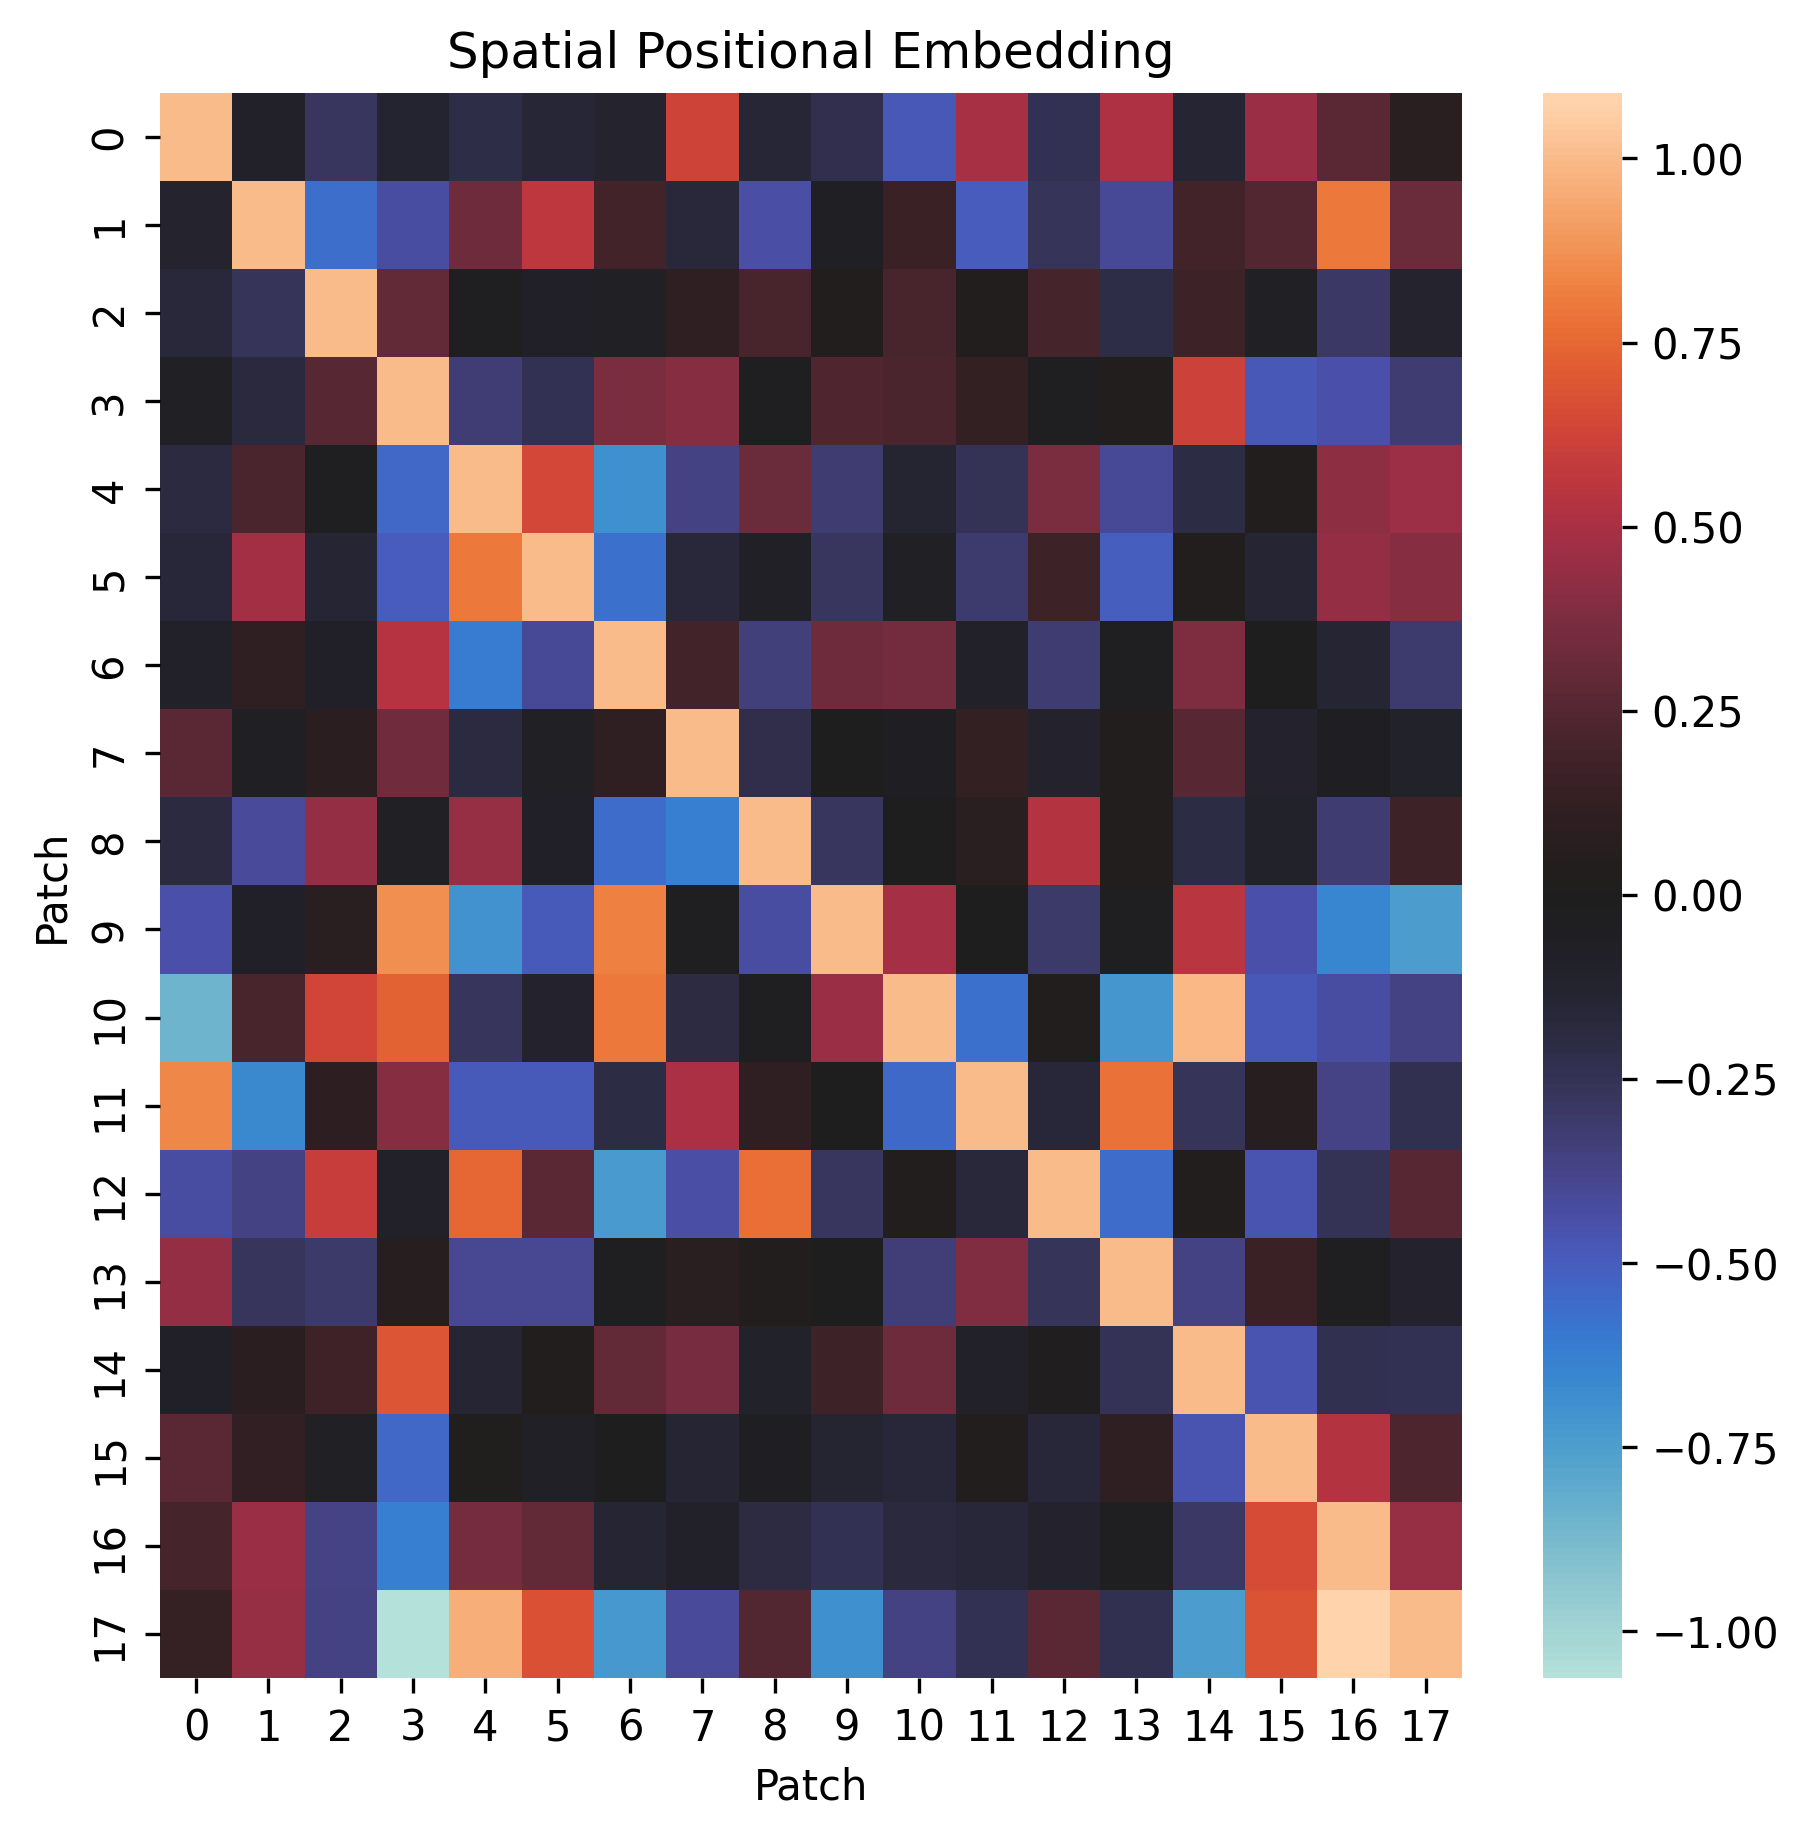

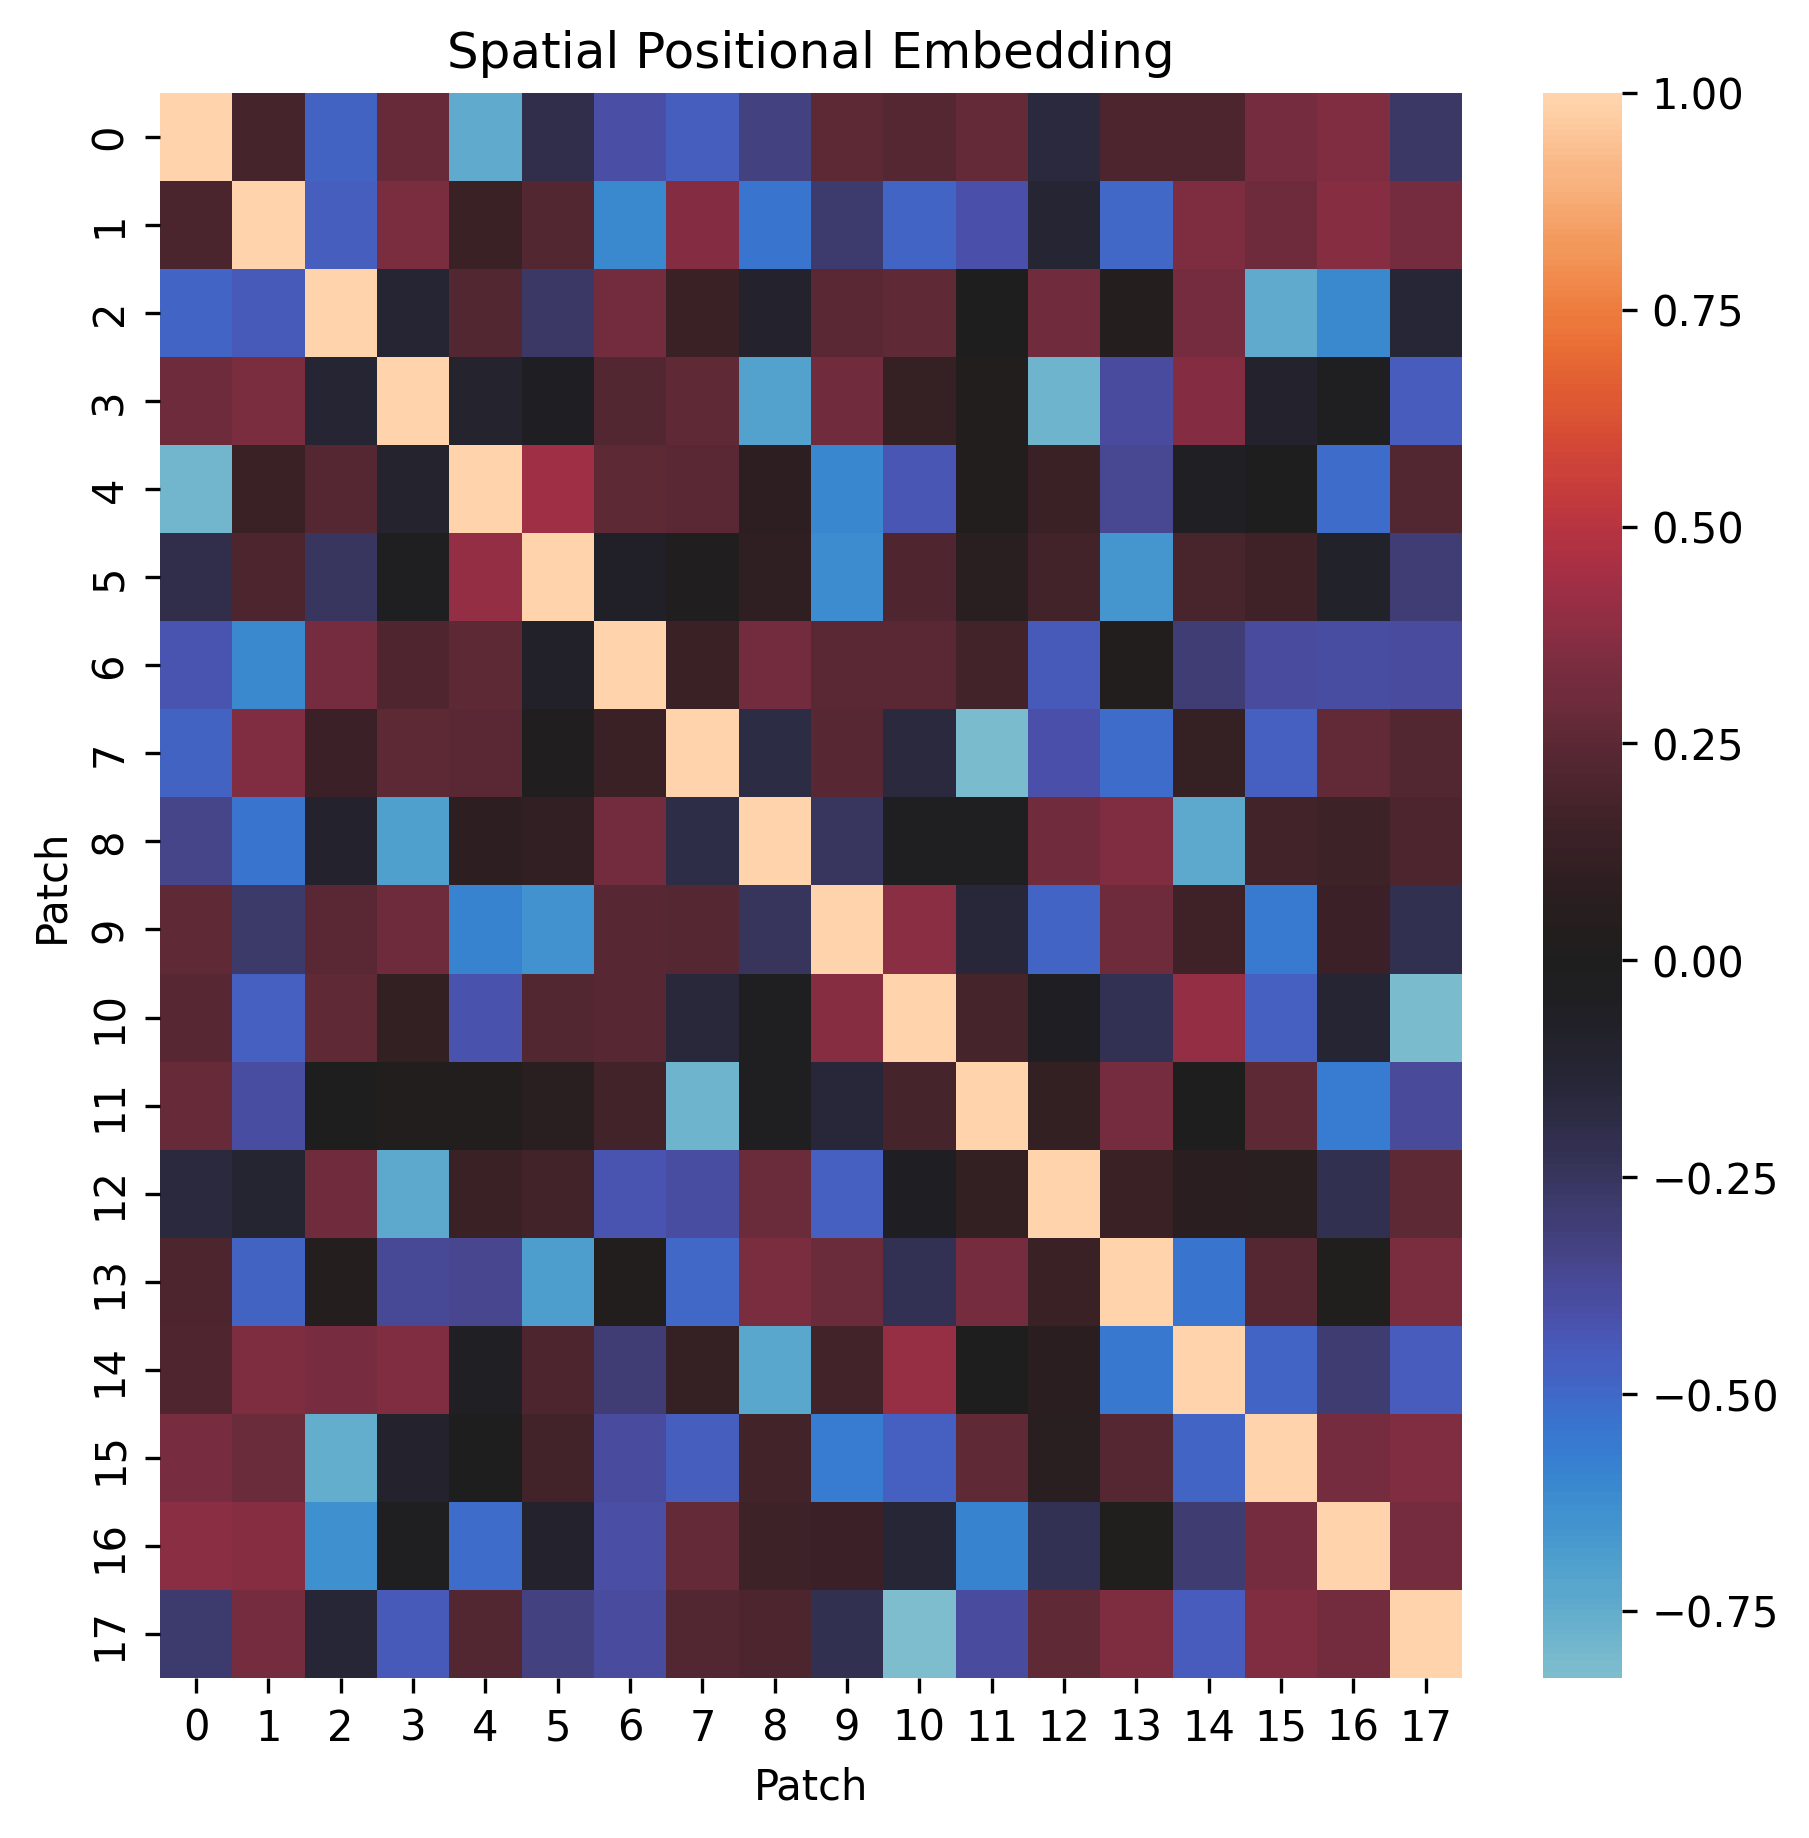

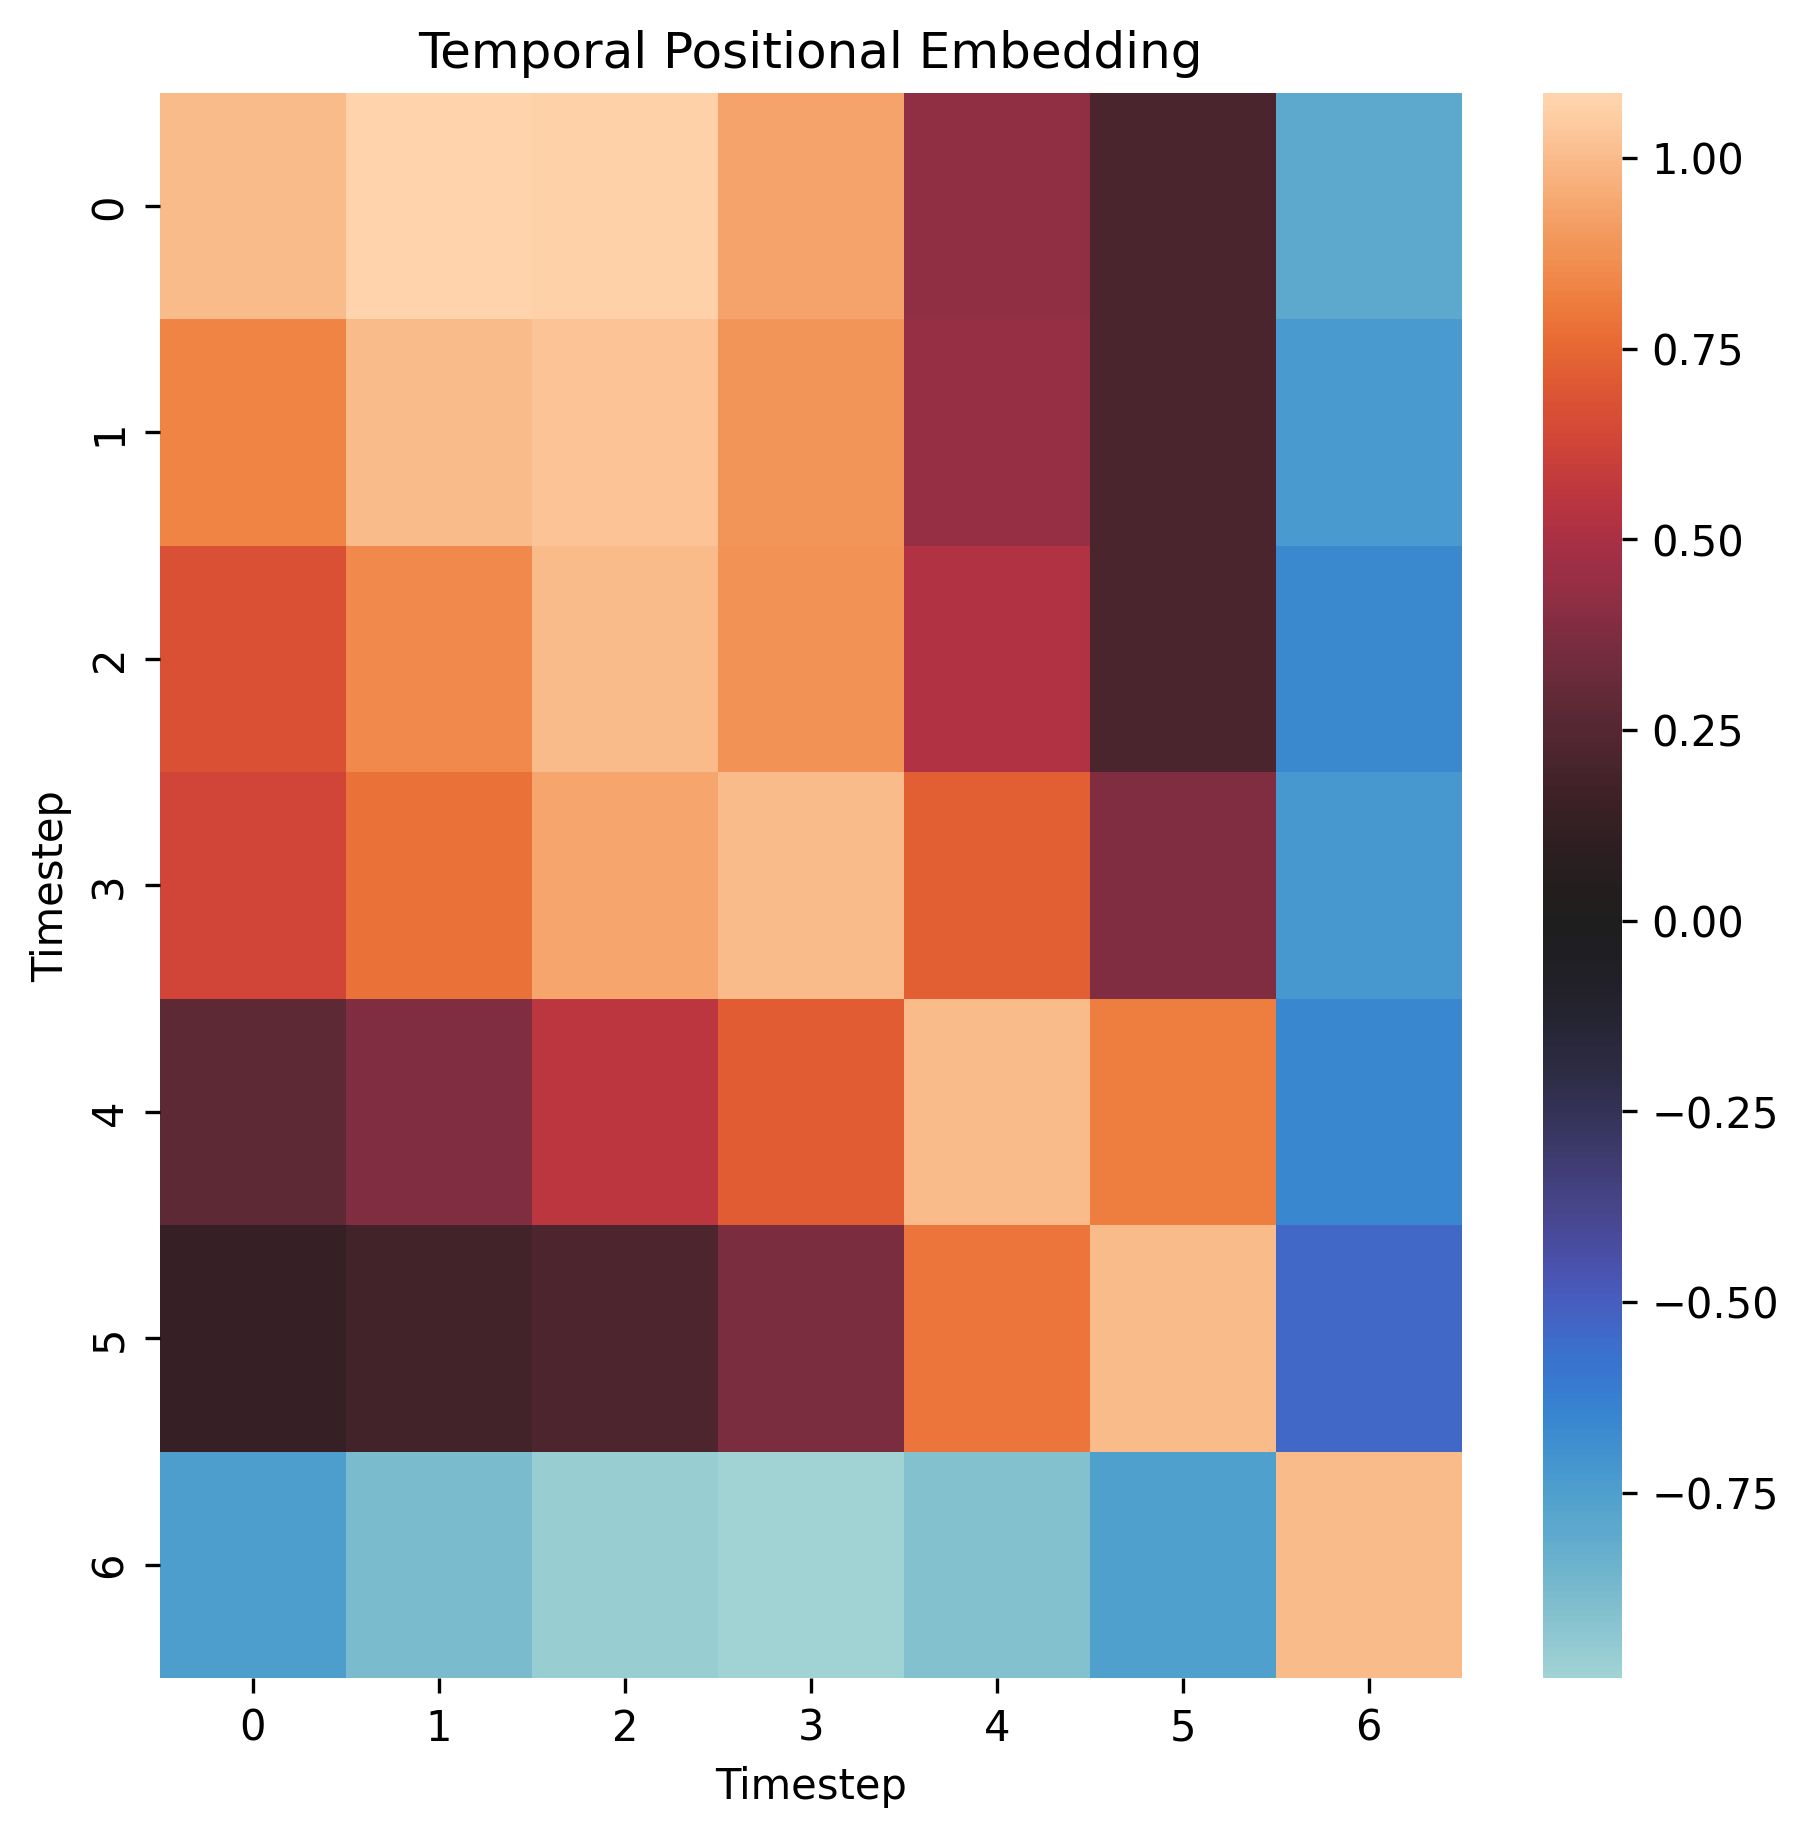

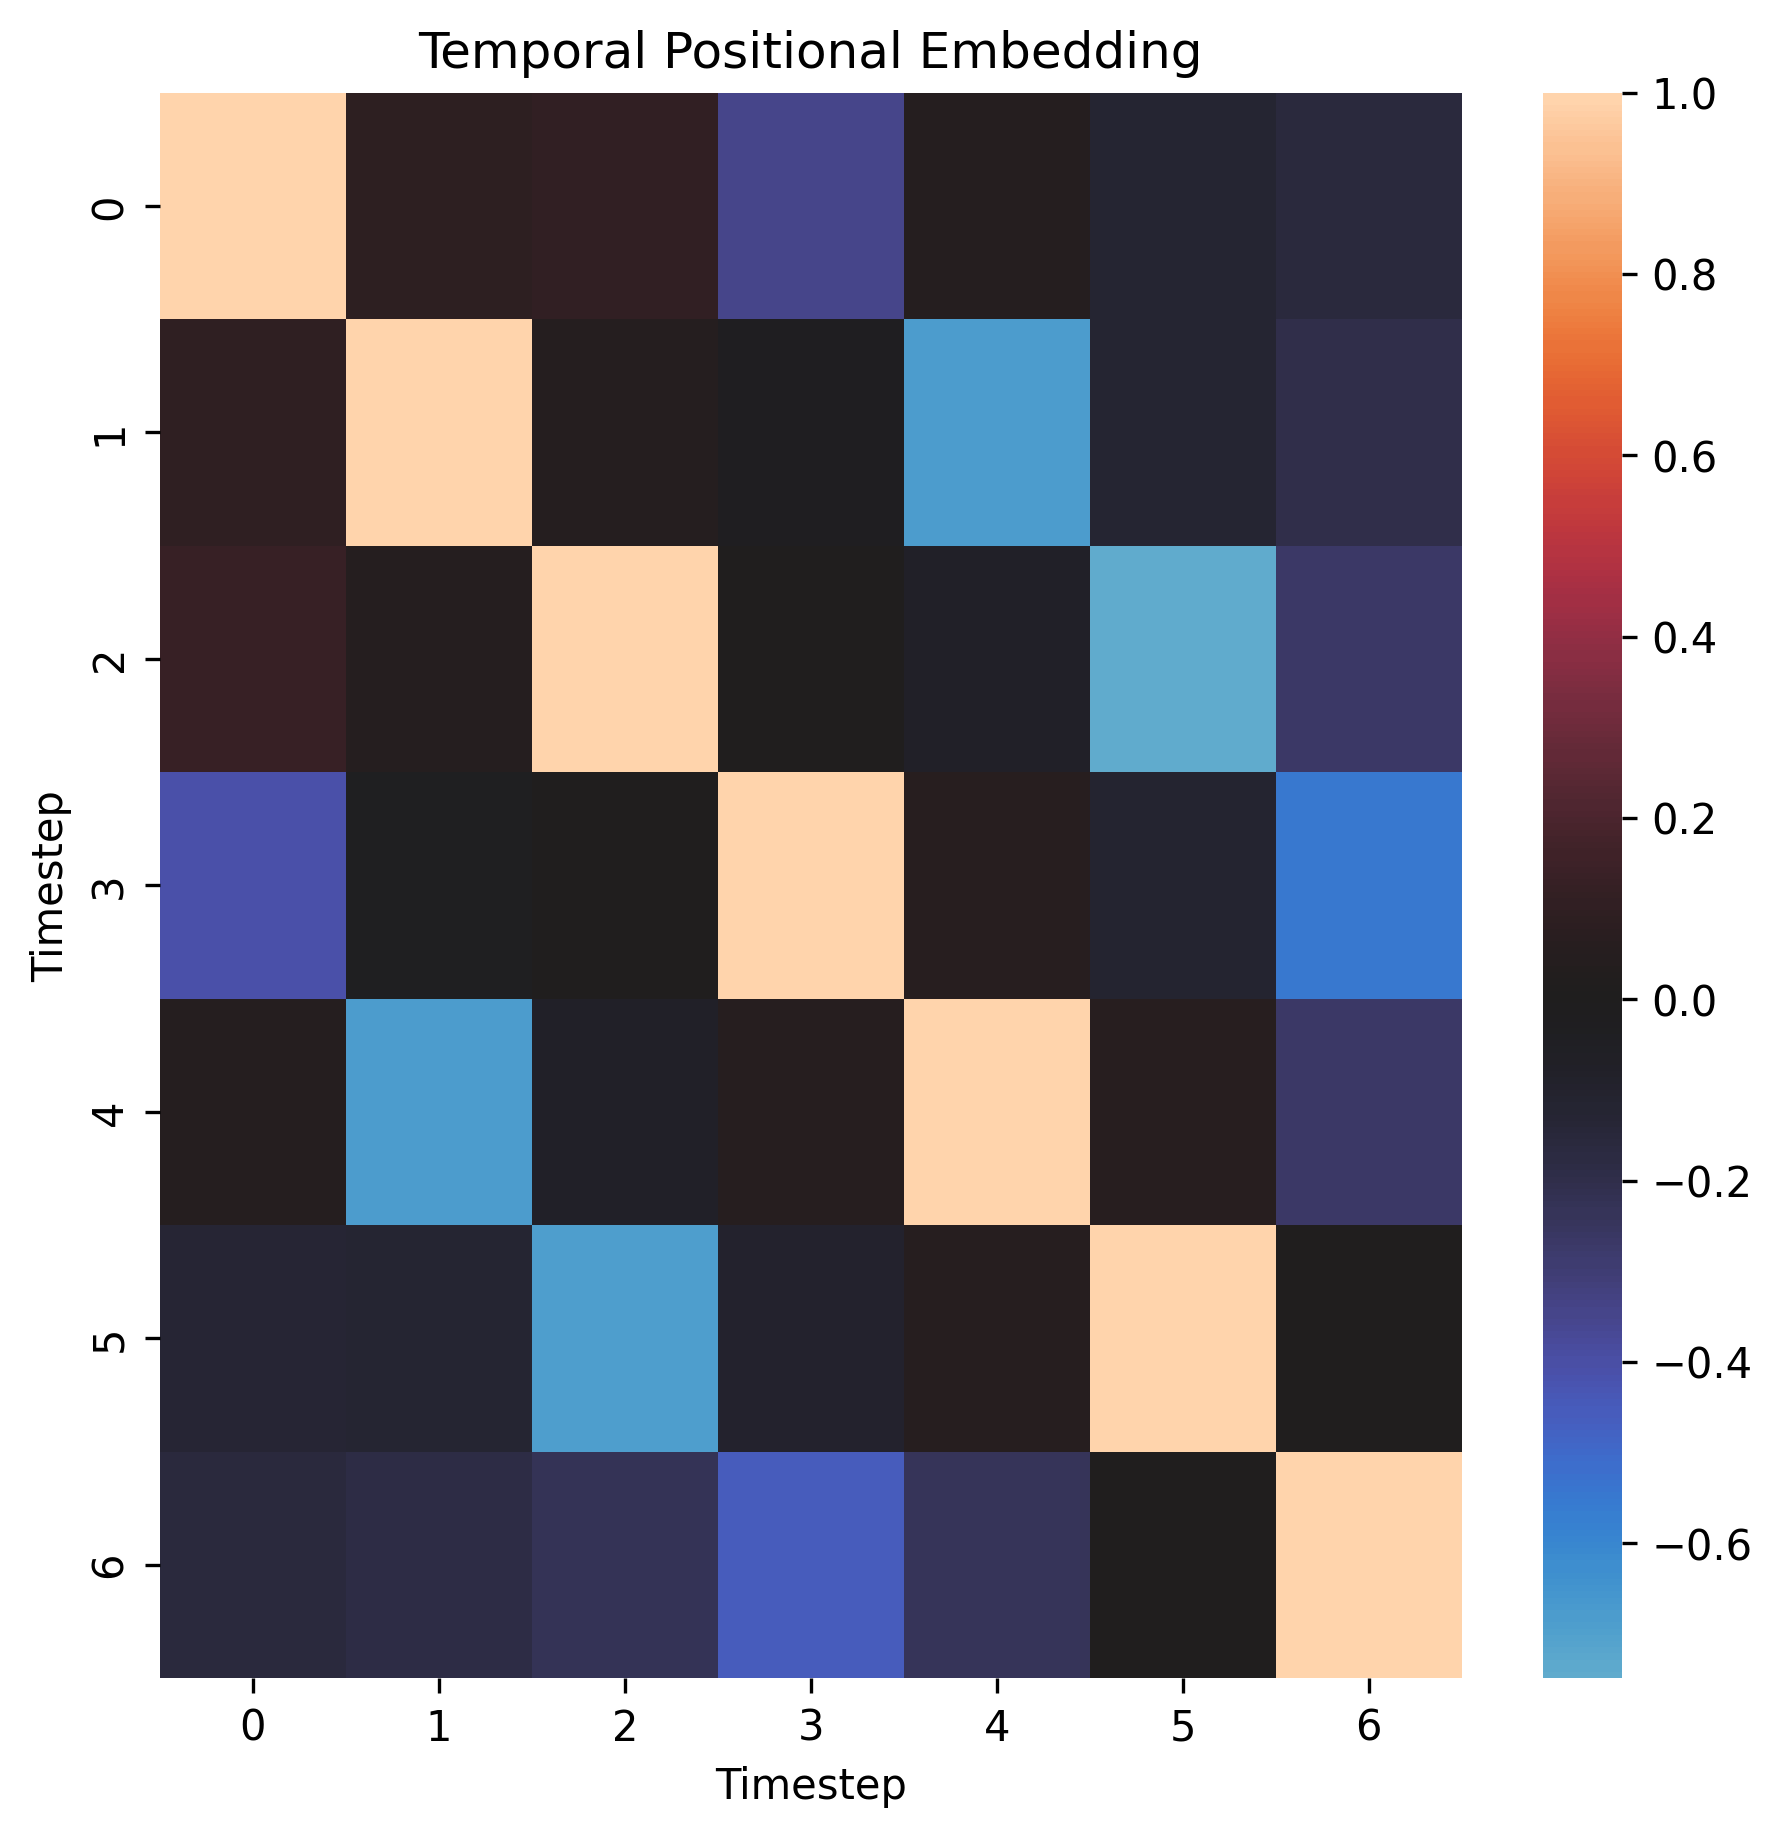

In [50]:
patch_similarity_plot(daily_model.pos_embs_0.spatial_position[0, 0])
patch_similarity_plot(daily_model.pos_embs_1.spatial_position[0, 0])

timestep_similarity_plot(daily_model.pos_embs_0.temporal_position[0, :, 0])
timestep_similarity_plot(daily_model.pos_embs_1.temporal_position[0, :, 0])

### Results

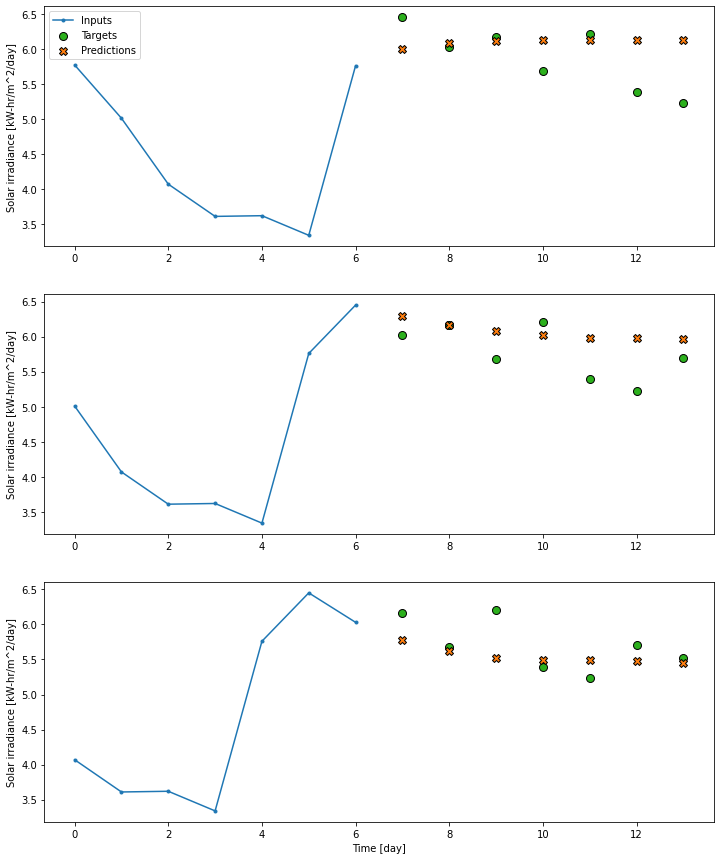

{'mean_squared_error': <tf.Tensor: shape=(), dtype=float32, numpy=0.9071774>, 'root_mean_squared_error': <tf.Tensor: shape=(), dtype=float32, numpy=0.9524587>, 'mean_absolute_error': <tf.Tensor: shape=(), dtype=float32, numpy=0.6726861>, 'r_square': <tf.Tensor: shape=(), dtype=float32, numpy=0.607384>}


In [51]:
metrics = [MeanSquaredError(), RootMeanSquaredError(), MeanAbsoluteError(), RSquare()]

# Location 1 = 15 (64.67 % na 4 dni), (80.6 % na 1 den)
# Location 2 = 16 (69.8 % na 4 dni), (83.67 % na 1 den)

for inputs in test_ds:
    inputs, targets = inputs
    inputs = inputs[:, :-horizon]
    targets_inputs = targets[:, :-horizon]
    targets_real = targets[:, -horizon:, 16, -1:]

    #y_pred = daily_model([inputs, targets_inputs], training=False)
    y_pred = simulator([inputs, targets_inputs], horizon_length=horizon)

    # Update the metrics
    for m in metrics:
        m.update_state(targets_real, y_pred[:, :, 16, -1:])

# visualize the last results
plot_prediction(targets, y_pred)

print({m.name: m.result() for m in metrics})